# Robot-dance model with optimal vaccination

In [1]:
import numpy as np
import gekko as gk
import matplotlib.pyplot as plt
%matplotlib inline

#plt.rcParams['figure.dpi'] = 600
#plt.rcParams['savefig.dpi'] = 600

Consider the problem 

\begin{split}
    \min_{u \in L_1([0,T])} &\sum_{i=1}^K c_v \int_0^T u_i(S_i + E_i + R_i)n_i \, dt + c_h \int_0^T r_h I_i n_i \, dt, \\[0.5px]
    \text{s.a. } &\sum_{j=1}^K V_i(t) n_i \le D(t), \text{ a.e. } t \in [0,T] \\[0.5px] 
    &u_i(t)\cdot (S_i(t) + E_i(t) + R_i(t)) \le D_i, \text{ a.e. } t \in [0,T] \\[0.5px]
    &u_i(t) \ge 0, i = 1,\dots,K, \text{ a.e. } t \in [0,T] \\[0.5px] 
    &\frac{dS_i}{dt} = -\alpha \beta_i S_i I_i - (1-\alpha) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}} - u_i S_i \\
    &\frac{dE_i}{dt} = \alpha \beta_i S_i I_i + (1-\alpha) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}} - \tau E_i - u_i E_i \\
    &\frac{dI_i}{dt} = \tau E_i - \gamma I_i \\
    &\frac{dR_i}{dt} = \gamma I_i - u_i R_i \\
    &\frac{dV_i}{dt} = u_i \cdot (S_i + E_i + R_i) \\
    &S_i(0) = s_{i0}, E_i(0) = e_{i0}, I_i(0) = i_{i0}, R_i(0) = r_{i0}, V_i(0) = 0.
\end{split}

In [34]:
def optimal_control_problem(parameters):
    
    # Gekko object
    m = gk.GEKKO()
    
    # Including the time
    T = parameters['T']
    npd = 20
    n_points = npd*T + 1
    m.time = np.linspace(0, T, n_points)

    # Number of cities
    populations = parameters['populations']
    K = len(populations)

    p = parameters['p_vector']
    p_matrix = np.eye(K)
    p_matrix[1:,0] = p
    p_matrix[1:, 1:] -= np.diag(p)
    population_eff = populations @ p_matrix

    # parameters
    beta = parameters['beta']
    cv = m.Const(parameters['cv'])
    ch = m.Const(parameters['ch'])
    rh = m.Const(parameters['rh'])
    alpha = m.Const(parameters['alpha'])
    tau = m.Const(parameters['tau'])
    gamma = m.Const(parameters['gamma'])
    
    c = parameters['c']
    
    # Constraints
    week_max = parameters['week_max']
    rate_max = parameters['rate_max']

    # Initial values
    e0 = parameters['e0']
    i0 = parameters['i0']
    r0 = parameters['r0']
    s0 = np.ones(K) - e0 - i0 - r0    

    # Including the variables
    s = m.Array(m.Var, K)
    e = m.Array(m.Var, K)
    i = m.Array(m.Var, K)
    r = m.Array(m.Var, K)
    
    # I am considering this variables multiplied by n_i to facilitate the calculations
    v = m.Array(m.Var, K)
    h = m.Array(m.Var, K)
    
    u = m.Array(m.MV, K)
    for city in range(K):
        s[city].value = s0[city]
        e[city].value = e0[city]
        i[city].value = i0[city]
        r[city].value = r0[city]
        
        s[city].lower = 0.0
        e[city].lower = 0.0
        i[city].lower = 0.0
        r[city].lower = 0.0
        
        v[city].value = 0.0
        h[city].value = 0.0

        u[city].value = 0.0
        u[city].STATUS = 1
        u[city].DCOST = 0
        u[city].lower = 0.0
    
    # Constants
    P = m.Array(m.Const, (K,K))
    B = m.Array(m.Const, K)
    N = m.Array(m.Const, (K,K))
    E_inv = m.Array(m.Const, (K,K))
    for city1 in range(K):
        for city2 in range(K):
            P[city1, city2].value = p_matrix[city1, city2]
        B[city1].value = beta[city1]
        if city1 == city2:
            N[city1,city1].value = populations[city1]
            E_inv[city1,city1].value = 1/population_eff[city1]
        else:
            N[city1,city2].value = 0.0
            E_inv[city1,city2].value = 0.0       

    # Maximizing 
    obj_points = np.zeros(n_points)
    obj_points[-1] = 1.0
    final = m.Param(value=obj_points)
    m.Obj(cv*v.sum()*final + ch*h.sum()*final)
    
    # normlizing population for numeric problems
    week_max = week_max/populations.sum()
    populations = populations/populations.sum()

    # ODE equations
    i_eff = E_inv@P.T@N@i
    new_infections = s[city] * (alpha*B[city]*i[city] + (1-alpha)*(beta*P[city,:]*i_eff).sum())
    for city in range(K):
        m.Equation(s[city].dt() == -new_infections - s[city]*u[city])
        m.Equation(e[city].dt() == new_infections - (tau+u[city])*e[city])
        m.Equation(i[city].dt() == tau*e[city] - gamma*i[city])
        m.Equation(r[city].dt() == gamma*i[city] - u[city]*r[city])
        m.Equation(v[city].dt() == u[city]*(s[city] + e[city] + r[city])*populations[city]*c[city])
        m.Equation(h[city].dt() == rh*i[city]*populations[city])
           
        # The vaccination rate is limited
        m.Equation(u[city]*(s[city] + e[city] + r[city]) <= rate_max[city])
        
    weekly_constraint = []
    weekly_mark = []
    for week in range(T//7):
        weekly_mark.append(np.zeros(n_points))
        weekly_mark[-1][npd*7*(week+1)] = 1.0
        weekly_constraint.append(m.Param(value=weekly_mark[-1]))
        m.Equation(v.sum()*weekly_constraint[-1] <= week_max[week])
        
    # Solving
    m.options.IMODE = 6
    m.options.NODES = 6
    m.options.MV_TYPE = 1
    #m.options.MAX_ITER = 400
    m.solve()
    
    return m, m.time, s, e, i, r, v, h, u

Enjoy the experiments!

In [48]:
populations = np.array([1e6, 1e4, 1e4])
# proportion that goes to the capital
p_vector = np.array([0.3, 0.3])
beta = np.array([0.5, 0.2, 0.2])
alpha = 1/2
tau = 1/3
gamma = 1/5

rate_max = np.array([0.9, 0.9, 0.9])/28
week_max = np.array([1e6/8, 2*1e6/8, 3*1e6/8, 4*1e6/8])

parameters = {'T': 28, 'populations': populations, 'p_vector': p_vector,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': np.array([0.001, 0.0005, 0.0005]), 
              'i0': np.array([0.005, 0.0025, 0.002]), 
              'r0': np.array([0.01, 0.0001, 0.0005]),
              'cv': 0.0, 'ch': 1000, 'rh': 0.1,
              'c': np.array([1.0, 1.1, 1.1]),
              'week_max': week_max,
              'rate_max': rate_max}

m, t, s, e, i, r, v, h, u = optimal_control_problem(parameters)

apm 201.39.147.24_gk_model5 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :           36
   Variables    :           33
   Intermediates:            0
   Connections  :            0
   Equations    :           26
   Residuals    :           26
 
 Number of state variables:         135520
 Number of total equations: -       133840
 Number of slack variables: -        19600
 ---------------------------------------
 Degrees of freedom       :         -17920
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

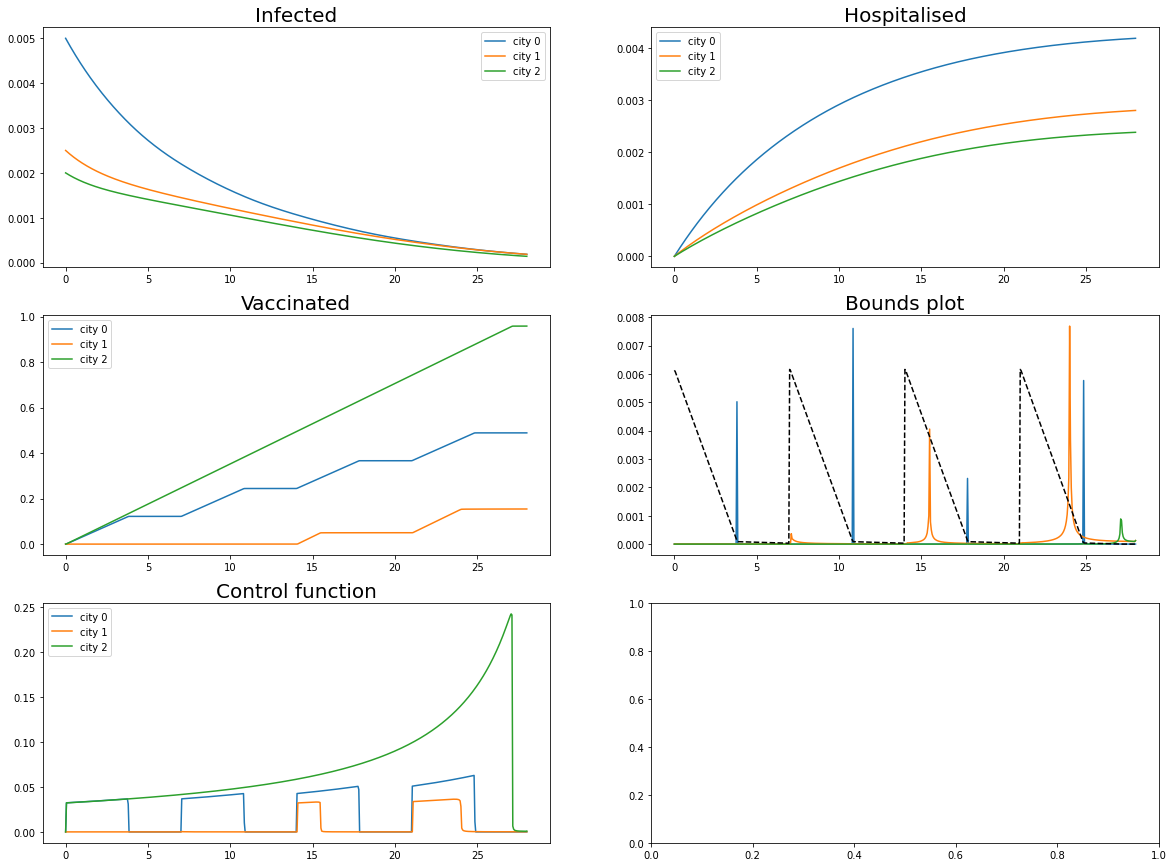

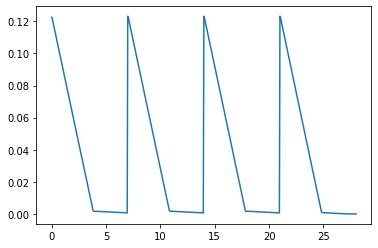

In [49]:
D_t = week_max[0]*(t < 7) + week_max[1]*(t>=7)*(t<14) + week_max[2]*(t>=14)*(t<21) + week_max[3]*(t>=21)*(t<=28)

fig, ax = plt.subplots(3,2, figsize=(20,15))

for city in range(len(populations)):
    ax[0,0].plot(t, i[city], label='city {}'.format(city))
    ax[0,1].plot(t, np.array(h[city])*populations.sum()/populations[city], label='city {}'.format(city))
    ax[1,0].plot(t, np.array(v[city])*populations.sum()/populations[city], label='city {}'.format(city))
    ax[1,1].plot(t, 
                 np.minimum(rate_max[city] - np.array(u[city])*(np.array(s[city])+np.array(e[city])+np.array(r[city])),
                            np.array(u[city])*(np.array(s[city])+np.array(e[city])+np.array(r[city]))), 
                 label='city {}'.format(city))
    
    ax[2,0].plot(t, u[city], label='city {}'.format(city))
    
ax[0,0].set_title('Infected', fontsize=20)
ax[0,1].set_title('Hospitalised', fontsize=20)
ax[1,0].set_title('Vaccinated', fontsize=20)
ax[1,1].set_title('Bounds plot', fontsize=20)
ax[2,0].set_title('Control function', fontsize=20)


ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[2,0].legend()

ax[1,1].plot(t,
             0.05*(D_t/populations.sum() - (np.array(v[0])+np.array(v[1])+np.array(v[2]))), 
             linestyle='--', color='black',
             label='weekly constraint')

plt.show()

plt.plot(t, D_t/populations.sum() - (np.array(v[0])+np.array(v[1])+np.array(v[2])))

In [2]:
import sympy as sp

In [49]:
tau, gamma, betai, wi, cv, ch, rh, ni, ci, di = sp.symbols('tau gamma beta_i w_i c_v c_h r_h n_i c_i d_i', real=True)
pi1, pi2, pi3, pi4 = sp.symbols('p_{5i-1} p_{5i-2} p_{5i-3} p_{5i-4}', real=True)
Si, Ei, Ii, Ri, ui = sp.symbols('S_i E_i I_i R_i u_i', real=True, positive=True)
dwidSi, dwidIi = sp.symbols('w_iS w_iI', real=True)
dwidSi = wi/Si

dSi = -wi - ui*Si
dEi = wi - ui*Ei - tau*Ei
dIi = tau*Ei - gamma*Ii
dRi = gamma*Ii - ui*Ri

dpi1 = pi1*ui
dpi4 = pi4*ui + (pi4 - pi3)*dwidSi
dpi3 = pi3*ui + (pi3 - pi2)*tau
dpi2 = ch*rh*ni + (pi4-pi3)*dwidIi + (pi2-pi1)*gamma

H_ui = -pi4*Si -pi3*Ei + -pi1*Ri

#pi2 = (ci -cv*ni)*(1-gamma*Ii/(tau*Ei)) + gamma*Ii/(tau*Ei)*pi1
#pi3 = ((ci - cv*ni)*(Si+Ei) + (ci-cv*ni-pi1)*Ri + Ei*((gamma*Ii/(tau*Ei*Ei)*(ci-cv*ni-pi1)*(wi - tau*Ei) + ch*rh*ni)/(dwidIi)))/(2*Ei)
#pi4 = ((ci - cv*ni)*(Si+Ei) + (ci-cv*ni-pi1)*Ri - Si*((gamma*Ii/(tau*Ei*Ei)*(ci-cv*ni-pi1)*(wi - tau*Ei) + ch*rh*ni)/(dwidIi)))/(2*Si)

In [29]:
dphi_i = -dpi4*Si -pi4*dSi - dpi3*Ei - pi3*dEi - dpi1*Ri -pi1*dRi
#dphi_i = sp.factor(sp.expand(sp.simplify(dphi_i)), [Ei, tau, Ii, gamma])
dphi_i

-E_i*(p_{5i-3}*u_i + tau*(-p_{5i-2} + p_{5i-3})) - R_i*p_{5i-1}*u_i + S_i*(-p_{5i-4}*u_i - w_i*(-p_{5i-3} + p_{5i-4})/S_i) - p_{5i-1}*(I_i*gamma - R_i*u_i) - p_{5i-3}*(-E_i*tau - E_i*u_i + w_i) - p_{5i-4}*(-S_i*u_i - w_i)

In [30]:
pi2_alt = sp.simplify(sp.factor(sp.solve(dphi_i, pi2)[0], [Ei, Ii]))
pi2_alt

I_i*gamma*p_{5i-1}/(E_i*tau)

In [31]:
dpi2_alt = (gamma/tau) * ( ((Ei*dIi - dEi*Ii)/Ei**2) * pi1 + (Ii/Ei) * dpi1 )
sp.factor(sp.simplify(dpi2_alt))

gamma*p_{5i-1}*(E_i**2*tau - E_i*I_i*gamma + E_i*I_i*tau + 2*E_i*I_i*u_i - I_i*w_i)/(E_i**2*tau)

In [32]:
sp.factor((Ii*dEi - Ei*dIi)/Ii**2)

-(E_i**2*tau - E_i*I_i*gamma + E_i*I_i*tau + E_i*I_i*u_i - I_i*w_i)/I_i**2

In [33]:
sp.factor(sp.solve(sp.simplify(Ei*Ei*tau*(dpi2 - dpi2_alt).subs({pi2: pi2_alt})), pi4-pi3)[0], [gamma, pi1])

-(E_i**2*c_h*n_i*r_h*tau + 2*E_i*I_i*gamma**2*p_{5i-1} + gamma*p_{5i-1}*(-2*E_i**2*tau - E_i*I_i*tau - 2*E_i*I_i*u_i + I_i*w_i))/(E_i**2*tau*w_iI)

In [34]:
ddphi_i = tau*(Ei*dpi2.subs({pi2: pi2_alt}) + dEi*pi2_alt) - gamma*(Ii*dpi1 + dIi*pi1)

In [35]:
sp.factor(sp.solve(sp.simplify(Ei*ddphi_i), pi4-pi3)[0], [gamma, pi1])

-(E_i**2*c_h*n_i*r_h*tau + 2*E_i*I_i*gamma**2*p_{5i-1} + gamma*p_{5i-1}*(-2*E_i**2*tau - E_i*I_i*tau - 2*E_i*I_i*u_i + I_i*w_i))/(E_i**2*tau*w_iI)

In [36]:
sp.solve(ddphi_i, ui)[0]

(-2*E_i**2*gamma*p_{5i-1}*tau + E_i**2*tau*(c_h*n_i*r_h - p_{5i-3}*w_iI + p_{5i-4}*w_iI) + E_i*I_i*gamma*p_{5i-1}*(2*gamma - tau) + I_i*gamma*p_{5i-1}*w_i)/(2*E_i*I_i*gamma*p_{5i-1})

In [37]:
ddphi_i

-gamma*(I_i*p_{5i-1}*u_i + p_{5i-1}*(E_i*tau - I_i*gamma)) + tau*(E_i*(c_h*n_i*r_h + gamma*(-p_{5i-1} + I_i*gamma*p_{5i-1}/(E_i*tau)) + w_iI*(-p_{5i-3} + p_{5i-4})) + I_i*gamma*p_{5i-1}*(-E_i*tau - E_i*u_i + w_i)/(E_i*tau))

In [50]:
#wi = betai*Si*Ii
H = -ch*rh*ni*Ii + betai*Si*Ii*(pi3-pi4) + tau*Ei*(pi2-pi3) + gamma*Ii*(pi1-pi2)

In [51]:
dH = -ch*rh*ni*dIi + betai*(dSi*Ii*(pi3-pi4) + Si*dIi*(pi3-pi4) + Si*Ii*(dpi3-dpi4)) + tau*dEi*(pi2-pi3) + tau*Ei*(dpi2-dpi3) + gamma*dIi*(pi1-pi2) + gamma*Ii*(dpi1-dpi2)

In [52]:
sp.simplify(dH.subs({dwidIi:betai*Si, wi: betai*Si*Ii}))

u_i*(-E_i*p_{5i-2}*tau + I_i*gamma*p_{5i-1})

In [48]:
wi

I_i*S_i*beta_i